In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.stats import anderson
from scipy.stats import shapiro

In [87]:
def auto_pick_center(image):
    height, width = image.shape
    center = (width // 2, height // 2)
    return center

In [88]:
def  manual_pick_center(image):
    center = np.array(image.shape) // 2
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            temp_image = image.copy()  # Create a copy of the original image
            cv2.circle(temp_image, (x, y), 5, (0, 255, 0), -1)  # Draw a green dot at the clicked point
            cv2.imshow("Image", temp_image)  # Show the image with the new dot
            nonlocal center
            center = np.array((x, y))

    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", mouse_callback)

    cv2.imshow("Image", image)
    while True:
        key = cv2.waitKey(1)
        if key == 27:
            break
    cv2.destroyAllWindows()
    return center

In [89]:
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))

In [90]:
def azimuthal_average(image, center=None):
    if center is None:
        center = np.array(image.shape) // 2  # Center at the middle if not specified
    
    y, x = np.indices(image.shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    r_bins = np.arange(0, int(np.ceil(r.max())) + 1)
    radial_sum = np.zeros(len(r_bins) - 1)
    bin_count = np.zeros(len(r_bins) - 1)
    
    for i in range(len(r_bins) - 1):
        in_bin = np.logical_and(r >= r_bins[i], r < r_bins[i + 1])
        radial_sum[i] = np.sum(image[in_bin])
        bin_count[i] = np.sum(in_bin)
    
    azimuthal_average = radial_sum / bin_count
    return azimuthal_average

In [37]:
def fit_gaussian_to_azimuthal_average(r, azimuthal_avg):
    popt, _ = curve_fit(gaussian, r, azimuthal_avg)
    return popt

In [38]:
def create_gaussian_beam_image(gray_image_shape, amplitude, mean, stddev):
    y, x = np.indices(gray_image_shape)
    r = np.sqrt((x - gray_image_shape[1] / 2)**2 + (y - gray_image_shape[0] / 2)**2)
    gaussian_beam = gaussian(r, amplitude, mean, stddev)
    return gaussian_beam

In [39]:
def calculate_corr_coef(image, gaussian):
    return np.corrcoef(image.flatten(), gaussian.flatten())[0, 1]

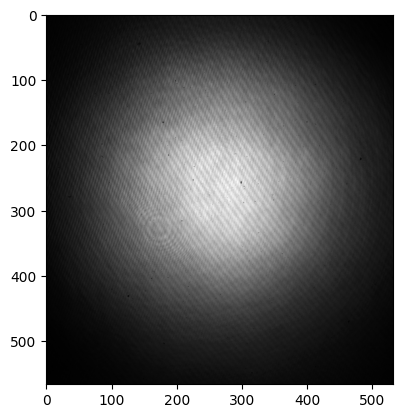

In [40]:
filename = 'beam1small.png'
color_image = cv2.imread(filename)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap = 'gray')

In [41]:
manual_center = manual_pick_center(gray_image)
auto_center = auto_pick_center(gray_image)

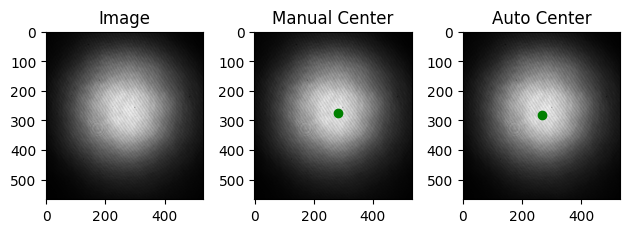

In [13]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Image')
axes[1].imshow(gray_image, cmap='gray')
axes[1].scatter(*manual_center, c='green')  # Scatter plot with manual_center
axes[1].set_title('Manual Center')
axes[2].imshow(gray_image, cmap='gray')
axes[2].scatter(*auto_center, c='green')  # Scatter plot with auto_center
axes[2].set_title('Auto Center')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



# plt.figure(figsize=(12, 9))
# plt.subplot(131), plt.imshow(gray_image, cmap='gray')
# plt.title('Original Image')
# plt.subplot(132), plt.imshow(image, cmap='gray'), plt.scatter(*manual_center, c='red')
# plt.title('Manual Centralised Image')
# plt.subplot(133), plt.imshow(image, cmap='gray'), plt.scatter(*auto_center, c='red')
# plt.title('Auto Centralised Image')

In [42]:
manual_azimuthal_avg = azimuthal_average(gray_image, manual_center)
auto_azimuthal_avg = azimuthal_average(gray_image, auto_center)

In [43]:
manual_radial_bins = np.arange(len(manual_azimuthal_avg))
auto_radial_bins = np.arange(len(auto_azimuthal_avg))

In [44]:
(manual_amplitude, manual_mean, manual_std_dev) = fit_gaussian_to_azimuthal_average(manual_radial_bins, manual_azimuthal_avg)
(auto_amplitude, auto_mean, auto_std_dev) = fit_gaussian_to_azimuthal_average(auto_radial_bins, auto_azimuthal_avg)

manual_curve_values = gaussian(manual_radial_bins, manual_amplitude, manual_mean, manual_std_dev)
auto_curve_values = gaussian(auto_radial_bins, auto_amplitude, auto_mean, auto_std_dev)


In [97]:
p0 = [np.max(manual_azimuthal_avg), np.mean(manual_azimuthal_avg), np.std(manual_azimuthal_avg)]
params, _ = curve_fit(gaussian, manual_radial_bins, manual_azimuthal_avg, p0=p0)

# Extract the fitted parameters
amplitude_fit, mean_fit, std_dev_fit = params

# Generate the Gaussian vector using fitted parameters
gaussian_vector = gaussian(manual_radial_bins, amplitude_fit, mean_fit, std_dev_fit)


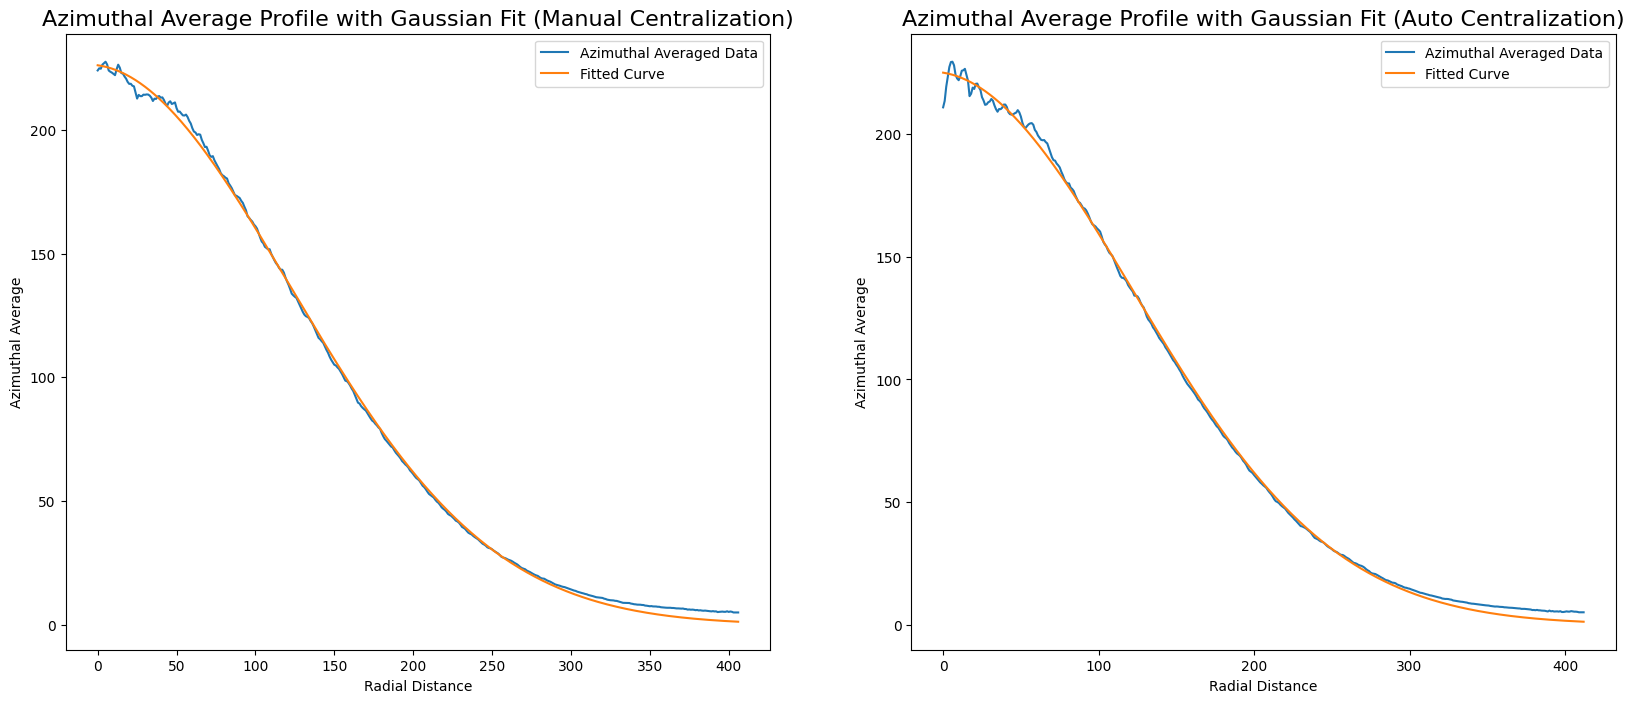

In [98]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(manual_azimuthal_avg, label='Azimuthal Averaged Data')
plt.plot(manual_curve_values, label='Fitted Curve')
plt.xlabel('Radial Distance')
plt.ylabel('Azimuthal Average')
plt.title('Azimuthal Average Profile with Gaussian Fit (Manual Centralization)', fontsize=16)
plt.legend()
plt.subplot(122)
plt.plot(auto_azimuthal_avg, label='Azimuthal Averaged Data')
plt.plot(auto_curve_values, label='Fitted Curve')
plt.xlabel('Radial Distance')
plt.ylabel('Azimuthal Average')
plt.title('Azimuthal Average Profile with Gaussian Fit (Auto Centralization)', fontsize=16)
plt.legend()

In [99]:
manual_gaussian_beam = create_gaussian_beam_image(gray_image.shape, manual_amplitude, manual_mean, manual_std_dev)
auto_gaussian_beam = create_gaussian_beam_image(gray_image.shape, auto_amplitude, auto_mean, auto_std_dev)
manual_corr_coef = calculate_corr_coef(gray_image, manual_gaussian_beam)
auto_corr_coef = calculate_corr_coef(gray_image, auto_gaussian_beam)

In [100]:
print("Fitted Gaussian Mean of Manual Cut Image:", manual_mean)
print("Fitted Gaussian Mean of Auto Cut Image:  ", auto_mean)
print("Fitted Gaussian Variance of Manual Cut Image:", manual_std_dev ** 2)
print("Fitted Gaussian Variance of Auto Cut Image:  ", auto_std_dev ** 2)
print("Correlation coefficient of between original and manual centralized images:", manual_corr_coef)
print("Correlation coefficient of between original and auto centralized images:  ", auto_corr_coef)

Fitted Gaussian Mean of Manual Cut Image: -6.3456368112970205
Fitted Gaussian Mean of Auto Cut Image:   -7.497106528722415
Fitted Gaussian Variance of Manual Cut Image: 16369.989105227944
Fitted Gaussian Variance of Auto Cut Image:   16669.93114955838
Correlation coefficient of between original and manual centralized images: 0.9763714438941757
Correlation coefficient of between original and auto centralized images:   0.9763217821518588


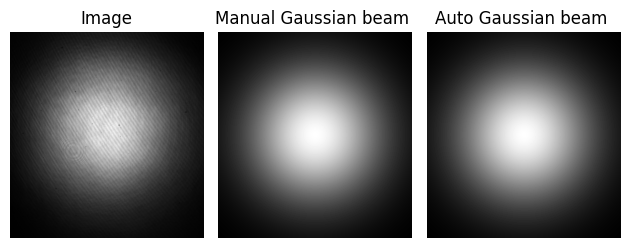

In [101]:
fig, axes = plt.subplots(1, 3)

# Display the first image
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Image')
axes[0].axis('off')  # Turn off axis labels for better visualization

# Display the second image with a scatter plot using manual_center
axes[1].imshow(manual_gaussian_beam, cmap='gray')
axes[1].set_title('Manual Gaussian beam ')
axes[1].axis('off')

axes[2].imshow(auto_gaussian_beam, cmap='gray')
axes[2].set_title('Auto Gaussian beam ')
axes[2].axis('off')
plt.tight_layout()